# K Fold Cross Validation (2) (최종)
- 대상 파일: `Modified/ufo/train.json`
- train set과 validation set을 나누어보자.
- `sklearn`의 `StratifiedGroupKFold`를 사용한다.
    - group = image
    - class = bbox_size 별

## 1. train data EDA - 기본
- `OCR_EDA_train.ipynb` 참고

In [1]:
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import numpy as np

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

In [4]:
# gt file과 raw image file path를 이용해 데이터를 불러온다. 아래 경로는 예시.
data = read_json("/opt/ml/input/data/Modified/ufo/train.json")

In [5]:
def get_box_size(quads):
    """ 단어 영역의 사각형 좌표가 주어졌을 때 가로, 세로길이를 계산해주는 함수.
    TODO: 각 변의 길이를 단순히 max로 처리하기때문에 직사각형에 가까운 형태가 아니면 약간 왜곡이 있다.
    Args:
        quads: np.ndarray(n, 4, 2) n개 단어 bounding-box의 4개 점 좌표 (단위 pixel)
    Return:
        sizes: np.ndarray(n, 2) n개 box의 (height, width)쌍
    """
    dists = []
    for i, j in [(1, 2), (3, 0), (0, 1), (2, 3)]: # [right(height), left(height), upper(width), lower(width)] sides
        dists.append(np.linalg.norm(quads[:, i] - quads[:, j], ord=2, axis=1))

    dists = np.stack(dists, axis=-1).reshape(-1, 2, 2) # shape (n, 2, 2) widths, heights into separate dim
    return np.rint(dists.mean(axis=-1)).astype(int)

In [6]:
def rectify_poly(poly, direction, img_w, img_h):
    """일반 polygon형태인 라벨을 크롭하고 rectify해주는 함수.
    Args:
        poly: np.ndarray(2n+4, 2) (where n>0), 4, 6, 8
        image: np.ndarray opencv 포멧의 이미지
        direction: 글자의 읽는 방향과 진행 방향의 수평(Horizontal) 혹은 수직(Vertical) 여부
    Return:
        rectified: np.ndarray(2, ?) rectify된 단어 bbox의 사이즈.
    """
    
    n_pts = poly.shape[0]
    assert n_pts % 2 == 0
    if n_pts == 4:
        size = get_box_size(poly[None])
        h = size[:, 0] / img_h
        w = size[:, 1] / img_w
        return np.stack((h,w))

    def unroll(indices):
        return list(zip(indices[:-1], indices[1:]))

    # polygon하나를 인접한 사각형 여러개로 쪼갠다.
    indices = list(range(n_pts))
    if direction == 'Horizontal':
        upper_pts = unroll(indices[:n_pts // 2]) # (0, 1), (1, 2), ... (4, 5)
        lower_pts = unroll(indices[n_pts // 2:])[::-1] # (8, 9), (7, 8), ... (6, 7)

        quads = np.stack([poly[[i, j, k, l]] for (i, j), (k, l) in zip(upper_pts, lower_pts)])
    else:
        right_pts = unroll(indices[1:n_pts // 2 + 1]) # (1, 2), (2, 3), ... (4, 5)
        left_pts = unroll([0] + indices[:n_pts // 2:-1]) # (0, 9), (9, 8), ... (7, 6)

        quads = np.stack([poly[[i, j, k, l]] for (j, k), (i, l) in zip(right_pts, left_pts)])

    sizes = get_box_size(quads)
    if direction == 'Horizontal':
        h = sizes[:, 0].max() / img_h
        widths = sizes[:, 1]
        w = np.sum(widths) / img_w
        return np.stack((h,w)).reshape(2,-1)
        #return np.stack((h,w))
    elif direction == 'Vertical':
        heights = sizes[:, 0]
        w = sizes[:, 1].max() / img_w
        h = np.sum(heights) / img_h
        return np.stack((h,w)).reshape(2,-1)
    else:
        h = sizes[:, 0] / img_h
        w = sizes[:, 1] / img_w
        return np.stack((h,w),-1)

In [7]:
df = {}
df['image'] = []
df['word_counts'] = []
df['image_width'] = []
df['image_height'] = []
df['image_tags'] = []
img_tags = []

quads = []
polys = []
seq_length = []
hor_sizes = []
ver_sizes = []
irr_sizes = []
languages = []
orientation = []
word_tags = []
aspect_ratio = []
ver_string = []
# add
image_name = []

for image_key, image_value in data["images"].items():
    df['image'].append(image_key)
    img_w = image_value['img_w']
    img_h = image_value['img_h']
    df['image_width'].append(img_w)
    df['image_height'].append(img_h)
    df['image_tags'].append(image_value['tags'])
    df['image_tags']= [['None'] if v is None else v for v in df['image_tags']] # our data does not inlcude multi-tag images 
    word_ann = image_value['words']
    count_ill = 0 
    for word in word_ann.values():
        if word['illegibility']== False:
            orientation.append(word['orientation'])
            orientation = [v for v in orientation]
            seq_length.append(len(word['transcription']))
            languages.append(word['language'])
            languages = [['None'] if v is None else v for v in languages] # our data does not inlcude multi-language words
            if word['word_tags'] != None:
                word_tags.extend(word['word_tags'][:])
            elif word['word_tags']== None:
                word_tags.append('None')
            poly = np.int32(word['points'])
            size = rectify_poly(poly, word['orientation'], img_w, img_h)
            if word['orientation'] == 'Horizontal':
                hor_sizes.append(size)
            elif word['orientation'] == 'Vertical':
                ver_sizes.append(size)
            else:
                irr_sizes.append(size)
            
            # add
            image_name.append(image_key)
            
        else:
            count_ill += 1
    df['word_counts'].append(len(word_ann)-count_ill)

        
all_sizes = hor_sizes + ver_sizes + irr_sizes
quad_area = [all_sizes[i][0]*all_sizes[i][1] for i in range(len(all_sizes))]
total_area = []
for s in quad_area:
    if s.shape[0] == 1:
        total_area.append(np.sum(s[0])) 
    else:
        total_area.append(np.sum(s))

hor_aspect_ratio = [hor_sizes[i][1]/hor_sizes[i][0] for i in range(len(hor_sizes))]
ver_aspect_ratio = [ver_sizes[i][1]/ver_sizes[i][0] for i in range(len(ver_sizes))]

image_df = pd.DataFrame.from_dict(df)

/tmp/ipykernel_25859/495774133.py:70: RuntimeWarning: invalid value encountered in true_divide
  hor_aspect_ratio = [hor_sizes[i][1]/hor_sizes[i][0] for i in range(len(hor_sizes))]


In [8]:
image_df['image_tags'] = image_df['image_tags'].apply(lambda x: ','.join(map(str, x)))
image_df

,image,word_counts,image_width,image_height,image_tags
0,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,20,1440,1440,None
1,1595697184898-0.jpg,9,960,720,None
2,1607662862521-14.jpg,4,1080,1440,None
3,1610698978661-5.jpg,61,3024,4032,None
4,1613386234855-5.jpg,16,3024,4032,None
...,...,...,...,...,...
2333,img_1187.jpg,1,3024,2268,None
2334,img_1196.jpg,23,2448,1836,None
2335,img_1066.jpg,4,2448,1836,None
2336,img_604.jpg,33,1600,1200,None


In [9]:
image_df.describe()

,word_counts,image_width,image_height
count,2338.000000,2338.000000,2338.000000
mean,24.890077,2888.024808,2945.495723
std,30.429058,1399.065176,1873.318300
min,0.000000,372.000000,278.000000
25%,7.000000,1836.000000,1836.000000
50%,15.000000,2448.000000,2448.000000
75%,32.000000,3264.000000,3096.000000
max,333.000000,9248.000000,9248.000000


In [10]:
first_img = list(data['images'].keys())[0]
data["images"][first_img].keys()

dict_keys(['paragraphs', 'words', 'chars', 'img_w', 'img_h', 'tags', 'relations', 'annotation_log', 'license_tag'])

In [11]:
def create_count_df(df, field, index):
    count=df.groupby(field)[index].count().sort_values(ascending=False)
    count_df = count.to_frame().reset_index()
    count_df.columns = [field, field + '_count']
    return count_df

def plot_count_df(df, field, random_sample, color, rotation, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10,6))
    if random_sample:
        df = df.sample(n=50, random_state=1)
    bars = ax.bar(df[field], df[field + '_count'], color=color, align='center',alpha=0.5)
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
                df.iloc[i][field + '_count'],ha='center',fontsize=13)
    ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()
    

In [12]:
def plot_dist(df, field, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(18,6))
    sns.distplot(df[field], bins=bins, color=color, ax=ax)
    
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

## 2. train data EDA - bbox_size에 따라 구간 나누기

In [13]:
word_df ={}
word_df['image'] = image_name
word_df['index'] = [i for i in range(len(total_area))]
word_df['orientation'] = orientation
word_df['language'] = languages
word_df['bbox_size'] = total_area

In [14]:
word_df = pd.DataFrame.from_dict(word_df)

In [15]:
word_df['language'] = word_df['language'].apply(lambda x: ','.join(map(str, x)))
word_df

,image,index,orientation,language,bbox_size
0,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,0,Horizontal,en,0.025027
1,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,1,Horizontal,en,0.060093
2,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,2,Horizontal,en,0.009290
3,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,3,Horizontal,en,0.012470
4,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,4,Horizontal,ko,0.010216
...,...,...,...,...,...
58188,img_1089.jpg,58188,Horizontal,en,0.002820
58189,img_1089.jpg,58189,Horizontal,en,0.002961
58190,img_1089.jpg,58190,Horizontal,ko,0.001856
58191,img_1089.jpg,58191,Horizontal,ko,0.002818


In [16]:
word_df.describe()['bbox_size']

count    58193.000000
mean         0.004980
std          0.017904
min          0.000000
25%          0.000247
50%          0.000775
75%          0.002562
max          0.423604
Name: bbox_size, dtype: float64

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


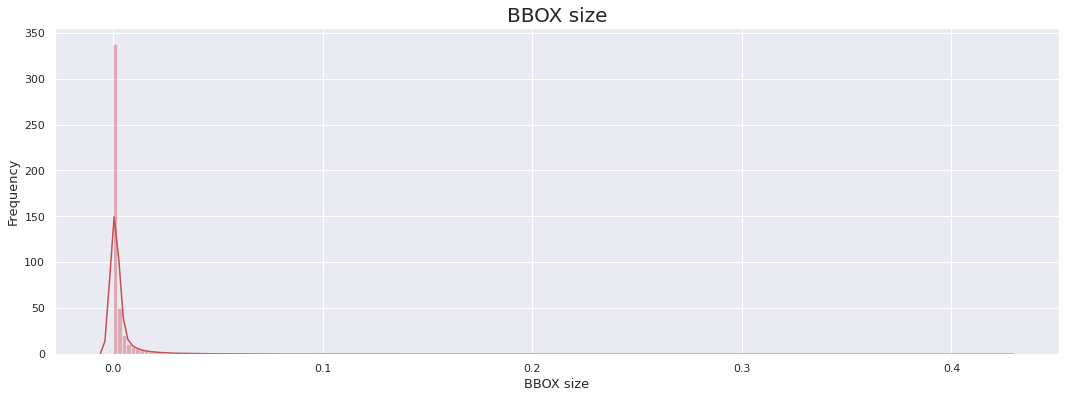

In [17]:
plot_dist(df=word_df, field='bbox_size', bins=200, color='r', xlabel='BBOX size', \
          ylabel='Frequency', title='BBOX size')

In [18]:
word_df['bbox_size']

0        0.025027
1        0.060093
2        0.009290
3        0.012470
4        0.010216
           ...   
58188    0.002820
58189    0.002961
58190    0.001856
58191    0.002818
58192    0.003469
Name: bbox_size, Length: 58193, dtype: float64

### 2.1 25%, 50%, 75% 기준으로 구간 나누어보기
- 단순 확인용

In [19]:
print(word_df.describe()['bbox_size']['min'])
print(word_df.describe()['bbox_size']['max'])

0.0
0.4236038208150201


In [20]:
word_df_1 = word_df.loc[word_df['bbox_size'] <= word_df.describe()['bbox_size']['25%']]
word_df_1.head(10)
print(min(word_df_1['bbox_size']), max(word_df_1['bbox_size']))
print(min(word_df_1['bbox_size']) / max(word_df_1['bbox_size']))

,image,index,orientation,language,bbox_size
28,1595697184898-0.jpg,28,Horizontal,,0.000078
34,1610698978661-5.jpg,34,Vertical,ko,0.000152
49,1610698978661-5.jpg,49,Horizontal,others,0.000129
52,1610698978661-5.jpg,52,Horizontal,ko,0.000122
53,1610698978661-5.jpg,53,Horizontal,ko,0.000196
54,1610698978661-5.jpg,54,Horizontal,ko,0.000222
55,1610698978661-5.jpg,55,Horizontal,ko,0.000157
56,1610698978661-5.jpg,56,Horizontal,ko,0.000235
61,1610698978661-5.jpg,61,Horizontal,ko,0.000155
62,1610698978661-5.jpg,62,Horizontal,ko,0.000222


0.0 0.0002467036197194927
0.0


In [21]:
word_df_2 = word_df.loc[
    (word_df['bbox_size'] > word_df.describe()['bbox_size']['25%']) &
    (word_df['bbox_size'] <= word_df.describe()['bbox_size']['50%'])]
word_df_2.head(10)
print(min(word_df_2['bbox_size']), max(word_df_2['bbox_size']))
print(min(word_df_2['bbox_size']) / max(word_df_2['bbox_size']))

,image,index,orientation,language,bbox_size
23,1595697184898-0.jpg,23,Horizontal,ko,0.000347
24,1595697184898-0.jpg,24,Horizontal,ko,0.000586
26,1595697184898-0.jpg,26,Horizontal,en,0.000304
27,1595697184898-0.jpg,27,Horizontal,en,0.000255
32,1607662862521-14.jpg,32,Vertical,en,0.000421
33,1610698978661-5.jpg,33,Vertical,ko,0.000692
35,1610698978661-5.jpg,35,Horizontal,ko,0.000568
36,1610698978661-5.jpg,36,Horizontal,ko,0.000395
37,1610698978661-5.jpg,37,Horizontal,,0.000381
41,1610698978661-5.jpg,41,Horizontal,en,0.000512


0.0002467256238949885 0.0007750956822235435
0.3183163441024446


In [22]:
word_df_3 = word_df.loc[
    (word_df['bbox_size'] > word_df.describe()['bbox_size']['50%']) &
    (word_df['bbox_size'] <= word_df.describe()['bbox_size']['75%'])]
word_df_3.head(10)
print(min(word_df_3['bbox_size']), max(word_df_3['bbox_size']))
print(min(word_df_3['bbox_size']) / max(word_df_3['bbox_size']))

,image,index,orientation,language,bbox_size
16,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,16,Horizontal,ko,0.001040
19,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,19,Horizontal,ko,0.001435
25,1595697184898-0.jpg,25,Horizontal,en,0.000787
40,1610698978661-5.jpg,40,Horizontal,ko,0.002166
44,1610698978661-5.jpg,44,Irregular,ko,0.002398
48,1610698978661-5.jpg,48,Horizontal,en,0.001567
90,1610698978661-5.jpg,90,Horizontal,ko,0.001754
91,1610698978661-5.jpg,91,Horizontal,en,0.001881
92,1610698978661-5.jpg,92,Horizontal,,0.002419
94,1613386234855-5.jpg,94,Horizontal,en,0.000844


0.0007751926342432398 0.0025622142684674112
0.30254793433295546


In [23]:
word_df_4 = word_df.loc[word_df['bbox_size'] > word_df.describe()['bbox_size']['75%']]
word_df_4.head(10)
print(min(word_df_4['bbox_size']), max(word_df_4['bbox_size']))
print(min(word_df_4['bbox_size']) / max(word_df_4['bbox_size']))

,image,index,orientation,language,bbox_size
0,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,0,Horizontal,en,0.025027
1,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,1,Horizontal,en,0.060093
2,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,2,Horizontal,en,0.009290
3,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,3,Horizontal,en,0.012470
4,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,4,Horizontal,ko,0.010216
5,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,5,Horizontal,en,0.005285
6,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,6,Horizontal,en,0.002582
7,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,7,Horizontal,ko,0.005064
8,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,8,Horizontal,ko,0.007268
9,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,9,Horizontal,ko,0.006644


0.0025628306878306877 0.4236038208150201
0.0060500650888836716


### [추가] 너무 크거나 작은 bbox는 없애자.
> 58193 rows -> 34923 rows
- 0.0005 미만
- 0.27 초과

In [24]:
idx_to_drop = word_df[(word_df["bbox_size"] < 0.0005) | (word_df["bbox_size"] > 0.27)].index
print(idx_to_drop)

Int64Index([   23,    26,    27,    28,    32,    34,    36,    37,    42,
               43,
            ...
            58147, 58148, 58149, 58150, 58151, 58157, 58180, 58181, 58182,
            58183],
           dtype='int64', length=23270)


In [25]:
# 확인용
word_df.iloc[idx_to_drop[43]]

image          1610698978661-5.jpg
index                           86
orientation             Horizontal
language                        ko
bbox_size                 0.000217
Name: 86, dtype: object

In [26]:
# 행 삭제
word_df = word_df.drop(idx_to_drop).reset_index(drop=True)
word_df["index"] = word_df.index
word_df

,image,index,orientation,language,bbox_size
0,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,0,Horizontal,en,0.025027
1,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,1,Horizontal,en,0.060093
2,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,2,Horizontal,en,0.009290
3,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,3,Horizontal,en,0.012470
4,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,4,Horizontal,ko,0.010216
...,...,...,...,...,...
34918,img_1089.jpg,34918,Horizontal,en,0.002820
34919,img_1089.jpg,34919,Horizontal,en,0.002961
34920,img_1089.jpg,34920,Horizontal,ko,0.001856
34921,img_1089.jpg,34921,Horizontal,ko,0.002818


### 2.2 `pd.qcut` 함수 사용해보기
- https://kongdols-room.tistory.com/175
- https://rfriend.tistory.com/404
- https://blog.naver.com/youji4ever/221671830297

In [27]:
word_df_cut = pd.qcut(word_df.bbox_size, [0, 0.3, 0.6, 0.8, 0.95, 1])
word_df_cut

0        (0.00721, 0.0345]
1           (0.0345, 0.27]
2        (0.00721, 0.0345]
3        (0.00721, 0.0345]
4        (0.00721, 0.0345]
               ...        
34918    (0.0027, 0.00721]
34919    (0.0027, 0.00721]
34920     (0.0011, 0.0027]
34921    (0.0027, 0.00721]
34922    (0.0027, 0.00721]
Name: bbox_size, Length: 34923, dtype: category
Categories (5, interval[float64, right]): [(-0.0005, 0.0011] < (0.0011, 0.0027] < (0.0027, 0.00721] < (0.00721, 0.0345] < (0.0345, 0.27]]

In [28]:
grouped = word_df.bbox_size.groupby(word_df_cut)

grouped.agg(['count', 'mean', 'std', 'min', 'max'])

,count,mean,std,min,max
bbox_size,,,,,
"(-0.0005, 0.0011]",10477,0.000760,0.000171,0.000500,0.001104
"(0.0011, 0.0027]",10477,0.001741,0.000454,0.001104,0.002703
"(0.0027, 0.00721]",6984,0.004383,0.001255,0.002704,0.007207
"(0.00721, 0.0345]",5238,0.015322,0.007122,0.007207,0.034474
"(0.0345, 0.27]",1747,0.078088,0.048079,0.034489,0.269680


In [29]:
# word_df에 bbox_size_group column 추가
word_df['bbox_size_cut'] = pd.qcut(word_df.bbox_size, [0, 0.3, 0.6, 0.8, 0.95, 1], labels=['A', 'B', 'C', 'D', 'E'])
word_df

,image,index,orientation,language,bbox_size,bbox_size_cut
0,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,0,Horizontal,en,0.025027,D
1,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,1,Horizontal,en,0.060093,E
2,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,2,Horizontal,en,0.009290,D
3,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,3,Horizontal,en,0.012470,D
4,0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG,4,Horizontal,ko,0.010216,D
...,...,...,...,...,...,...
34918,img_1089.jpg,34918,Horizontal,en,0.002820,C
34919,img_1089.jpg,34919,Horizontal,en,0.002961,C
34920,img_1089.jpg,34920,Horizontal,ko,0.001856,B
34921,img_1089.jpg,34921,Horizontal,ko,0.002818,C


## 3. train / val set 나누어보기
- `pd.qcut` 결과를 이용해서 `StratifiedGroupKFold`를 수행한다.
- `groups` = `image`
    - 같은 이미지가 동시에 train / val set에 들어가지 않도록 하기 위해서 image 이름을 group으로 설정한다.
- `y` = `bbox_size_cut`
    - bbox size별 구간(A ~ E)을 class처럼 생각한다.
- https://comlini8-8.tistory.com/97?category=896454

### 3.1 살펴보기

In [30]:
import json
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold

In [31]:
annotation = "/opt/ml/input/data/Modified/ufo/train.json"
target_dir = "/opt/ml/input/data/Modified/ufo"

In [32]:
with open(annotation) as f:
    data = json.load(f)

In [33]:
#data["images"]

In [34]:
word_df["image"]

0        0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG
1        0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG
2        0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG
3        0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG
4        0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG
                           ...                   
34918                                img_1089.jpg
34919                                img_1089.jpg
34920                                img_1089.jpg
34921                                img_1089.jpg
34922                                img_1089.jpg
Name: image, Length: 34923, dtype: object

In [35]:
# groups(image_id), y(bbox_size_cut)
var = []
for i in range(len(word_df)):
    var.append((word_df.iloc[i]["image"], word_df.iloc[i]["bbox_size_cut"]))

In [36]:
len(word_df)

34923

In [37]:
# 확인용
var[34922]

('img_1089.jpg', 'C')

In [38]:
X = np.ones((len(word_df)))
y = np.array([v[1] for v in var])
groups = np.array([v[0] for v in var])

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1333)

In [39]:
for train_idx, val_idx in cv.split(X, y, groups):    
    # train set과 valid set의 image_id가 겹치는지 확인
    assert len(set(groups[train_idx]) & set(groups[val_idx])) == 0

print("Success :)")

Success :)


### 3.2 잘 나누어졌는지 확인
- train / val set 간 중복되는 image가 있는지 확인한다.

In [40]:
import pandas as pd
from collections import Counter, defaultdict

In [41]:
# check distribution
def get_distribution(y):
    y_distr = Counter(y)
    y_vals_sum = sum(y_distr.values())
    
    return [f'{y_distr[i]/y_vals_sum:.2%}' for i in ['A', 'B', 'C', 'D', 'E']]

distrs = [get_distribution(y)]
index = ['training set']

for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    train_y, val_y = y[train_idx], y[val_idx]
    train_gr, val_gr = groups[train_idx], groups[val_idx]
    
    assert len(set(train_gr) & set(val_gr)) == 0
    
    distrs.append(get_distribution(train_y))
    distrs.append(get_distribution(val_y))
    
    index.append(f'train - fold{fold_idx}')
    index.append(f'val - fold{fold_idx}')
    
categories = ['A', 'B', 'C', 'D', 'E']

pd.DataFrame(distrs, index=index, columns = [categories[i] for i in range(len(categories))])

,A,B,C,D,E
training set,30.00%,30.00%,20.00%,15.00%,5.00%
train - fold0,29.98%,30.19%,19.97%,14.96%,4.91%
val - fold0,30.11%,29.18%,20.14%,15.17%,5.40%
train - fold1,29.73%,29.99%,20.05%,15.25%,4.98%
val - fold1,31.03%,30.05%,19.79%,14.03%,5.10%
train - fold2,30.37%,30.05%,19.86%,14.56%,5.16%
val - fold2,28.70%,29.82%,20.48%,16.54%,4.46%
train - fold3,29.83%,29.94%,20.03%,15.15%,5.05%
val - fold3,30.69%,30.23%,19.87%,14.38%,4.83%
train - fold4,30.10%,29.83%,20.08%,15.06%,4.93%


### 3.3 CV set 나눈 것으로 json 파일 만들기
- 위에서 확인만 했던 것을 json 파일로 만들어본다.
- https://github.com/boostcampaitech2/data-annotation-cv-level3-cv-14/blob/ab5ad99205ce1fed4ec4d5b8e236a95168082bac/dataset_spliter.py

In [42]:
import json
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
import os

train_src_path = "/opt/ml/input/data/Modified/ufo/train.json"
target_dir = "/opt/ml/input/data/Modified/ufo"

with open(train_src_path,'r') as f:
    train_src = json.load(f)

In [43]:
# train_src["images"]

In [44]:
# groups(image_id), y(bbox_size_cut)
var = []
for i in range(len(word_df)):
    var.append((word_df.iloc[i]["image"], word_df.iloc[i]["bbox_size_cut"]))

In [46]:
print(var[34922], len(var))

('img_1089.jpg', 'C') 34923


In [47]:
X = np.ones((len(word_df)))
y = np.array([v[1] for v in var])
groups = np.array([v[0] for v in var])

# seed?
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1333)

In [48]:
# 확인용 (첫 번째 fold)
train_idx, val_idx = next(cv.split(X, y, groups))
print("TRAIN:", groups[train_idx]) # image_name
print("      ", y[train_idx])  # bbox_size_cut
print(" TEST:", groups[val_idx]) 
print("      ", y[val_idx])

TRAIN: ['1607662862521-14.jpg' '1607662862521-14.jpg' '1607662862521-14.jpg' ...
 'img_1089.jpg' 'img_1089.jpg' 'img_1089.jpg']
       ['C' 'D' 'C' ... 'B' 'C' 'C']
 TEST: ['0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG'
 '0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG'
 '0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG' ... 'img_1196.jpg'
 'img_1196.jpg' 'img_1196.jpg']
       ['D' 'E' 'D' ... 'C' 'C' 'A']


In [49]:
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    ## groups(image_name), y(bbox_size_cut)
    # print("TRAIN:", groups[train_idx]) # image_name
    # print("      ", y[train_idx])  # bbox_size_cut
    # print(" TEST:", groups[val_idx]) 
    # print("      ", y[val_idx])
    
    train_gr, val_gr = groups[train_idx], groups[val_idx]
    
    # train set과 val set에 중복되는 image가 있는지 확인
    assert len(set(train_gr) & set(val_gr)) == 0
    
    train = {"images": {}}
    val = {"images": {}}
    
    # train set
    for img in train_gr:
        train["images"][img] = train_src["images"][img]
    print(f"len(train_{fold_idx}) = {len(train['images'])}")
    
    # val set
    for img in val_gr:
        val["images"][img] = train_src["images"][img]
    print(f"len(val_{fold_idx}) = {len(val['images'])}")
    
    with open(os.path.join(target_dir, f'train_{fold_idx}.json'), 'w') as f:
        json.dump(train, f, indent="\t")
    with open(os.path.join(target_dir, f'val_{fold_idx}.json'), 'w') as f:
        json.dump(val, f, indent="\t")
    
    print("Completed")

len(train_0) = 1691
len(val_0) = 423
Completed
len(train_1) = 1679
len(val_1) = 435
Completed
len(train_2) = 1693
len(val_2) = 421
Completed
len(train_3) = 1690
len(val_3) = 424
Completed
len(train_4) = 1703
len(val_4) = 411
Completed
